In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np

In [2]:
#defining transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

In [3]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

c:\Users\nithe\Documents\projects\cifar10\.venv\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [4]:
image, label = trainset[0]

print(f"Image Type: {type(image)}") 
print(f"Label Type: {type(label)}") 

print(f"Image Shape: {image.shape}") 

print(f"Label Index: {label}")
print(f"Class Name: {trainset.classes[label]}") 

Image Type: <class 'torch.Tensor'>
Label Type: <class 'int'>
Image Shape: torch.Size([3, 32, 32])
Label Index: 6
Class Name: frog


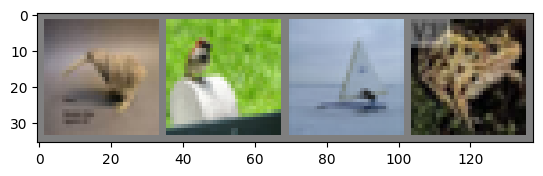

bird  bird  ship  frog 


In [5]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()    
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0) 

dataiter = iter(trainloader)
images, labels = next(dataiter) 

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{trainset.classes[labels[j]]:5s}' for j in range(4)))

In [6]:
#spliting ratio
train_ratio = 0.8
validation_ratio = 0.2

#define sizes
data_size = len(trainset)
train_size = int(train_ratio * data_size)
validation_size = data_size - train_size

In [7]:
#spliting data
train_set, valid_set = random_split(trainset, [train_size, validation_size])
print(len(train_set))   
print(len(valid_set))

40000
10000


In [8]:
#loading the data
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
test_data = DataLoader(valid_set, batch_size=64, shuffle=False)

In [ ]:
#define softmax classifier + hidden layer + relu
class softmax(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3 * 32 *32,256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self,x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x= F.relu(x)
        # self.dropout1 = nn.Dropout2d(0.25)
        x = self.fc2(x)

        return x

In [28]:
device = torch.device("cuda")

#creating model
linear_model = softmax().to(device)

#loss function
loss_func = nn.CrossEntropyLoss()

# print(linear_model.parameters())

#optimizer like gradient descent
optimizer = optim.SGD(linear_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [16]:
#training model
def epoch(epoch_index):

    linear_model.train()
    running_loss = 0.0
    epoch_loss_sum = 0.0 
    total_samples = 0

    for i, (inputs, labels) in enumerate(train_data):
        inputs, labels = inputs.to(device), labels.to(device)

        #zeroing gradients
        optimizer.zero_grad()

        #just inputs to make the model predict
        output = linear_model(inputs)
        
        #comparing the guessing vs ground truth
        loss = loss_func(output, labels)
        loss.backward()

        #adjust weights
        optimizer.step()
        
        #sending loss to the running function
        bs = inputs.size(0)
        running_loss += loss.item()
        epoch_loss_sum += loss.item() * bs
        total_samples += bs

        if i % 100 == 99:
            print(f'  batch {i + 1} loss: {running_loss/100:.4f}')
            running_loss = 0.

    return epoch_loss_sum / total_samples


In [19]:
def validate_epoch():

    linear_model.eval()
    loss_sum = 0.0
    total_samples = 0
    correct = 0
    
    with torch.no_grad():
        for inputs, labels in test_data:
            inputs, labels = inputs.to(device), labels.to(device)
            
            #getting raw predictions 
            outputs = linear_model(inputs)
            
            #calculating loss
            loss = loss_func(outputs, labels)
            
            bs = inputs.size(0)
            loss_sum += loss.item() * bs
            total_samples += bs
            
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            
    avg_loss = loss_sum / total_samples
    accuracy = 100.0 * correct / total_samples
    return avg_loss, accuracy

In [29]:
epochs = 5

for i in range(epochs):
    # Call the separate functions
    train_loss = epoch(i)
    val_loss, val_acc = validate_epoch()
    
    print(f"Epoch {i}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")

  batch 100 loss: 1.9407
  batch 200 loss: 1.7074
  batch 300 loss: 1.6633
  batch 400 loss: 1.6172
  batch 500 loss: 1.6056
  batch 600 loss: 1.5881
Epoch 0: Train Loss: 1.6824 | Val Loss: 1.5621 | Accuracy: 44.89%
  batch 100 loss: 1.5052
  batch 200 loss: 1.5060
  batch 300 loss: 1.4905
  batch 400 loss: 1.4777
  batch 500 loss: 1.4531
  batch 600 loss: 1.4589
Epoch 1: Train Loss: 1.4819 | Val Loss: 1.4733 | Accuracy: 48.22%
  batch 100 loss: 1.3615
  batch 200 loss: 1.4082
  batch 300 loss: 1.3898
  batch 400 loss: 1.3999
  batch 500 loss: 1.4075
  batch 600 loss: 1.3762
Epoch 2: Train Loss: 1.3922 | Val Loss: 1.4446 | Accuracy: 49.65%
  batch 100 loss: 1.3131
  batch 200 loss: 1.3109
  batch 300 loss: 1.3372
  batch 400 loss: 1.3111
  batch 500 loss: 1.3409
  batch 600 loss: 1.3306
Epoch 3: Train Loss: 1.3247 | Val Loss: 1.4247 | Accuracy: 50.22%
  batch 100 loss: 1.2159
  batch 200 loss: 1.2828
  batch 300 loss: 1.2942
  batch 400 loss: 1.3002
  batch 500 loss: 1.2671
  batch 600